# Assignment 2: Segmentation from Superpixels

Name: Arunava Basu

UID:  117720617

Link to Google Drive : https://colab.research.google.com/drive/1QPahsu-uyqzeQHSbWpVWMr8TBrIihLEF?usp=sharing

Please submit a PDF containing all outputs to gradescope by **November 30, 3:30pm**




The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 



Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Data
First, we download the MSRC labeled imaged database.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2021-11-30 17:47:02--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.27.220.188, 2600:1407:3c00:10a2::e59, 2600:1407:3c00:108c::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.27.220.188|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2021-11-30 17:47:02--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|184.27.220.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.0

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.

In [ ]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

Before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  # Remove the CWD from sys.path while we load stuff.


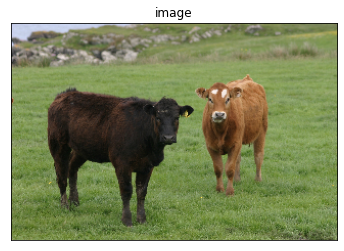

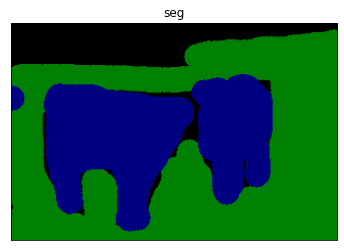

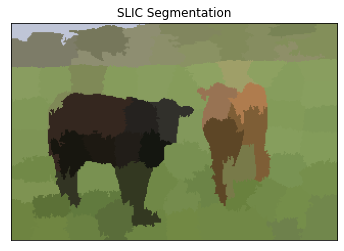

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from skimage.segmentation import slic
import os
import glob
import pandas as pd
from tqdm import tqdm
from IPython import embed

current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [ ]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": -1, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": -1, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": -1, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": -1, "name": "sheep",       "rgb_values": [0,   128,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.

rgb_2_label = {}
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    label_2_rgb[i['id']] = i['rgb_values']

## Question 1: Superpixel Dataset (30 points) 

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>




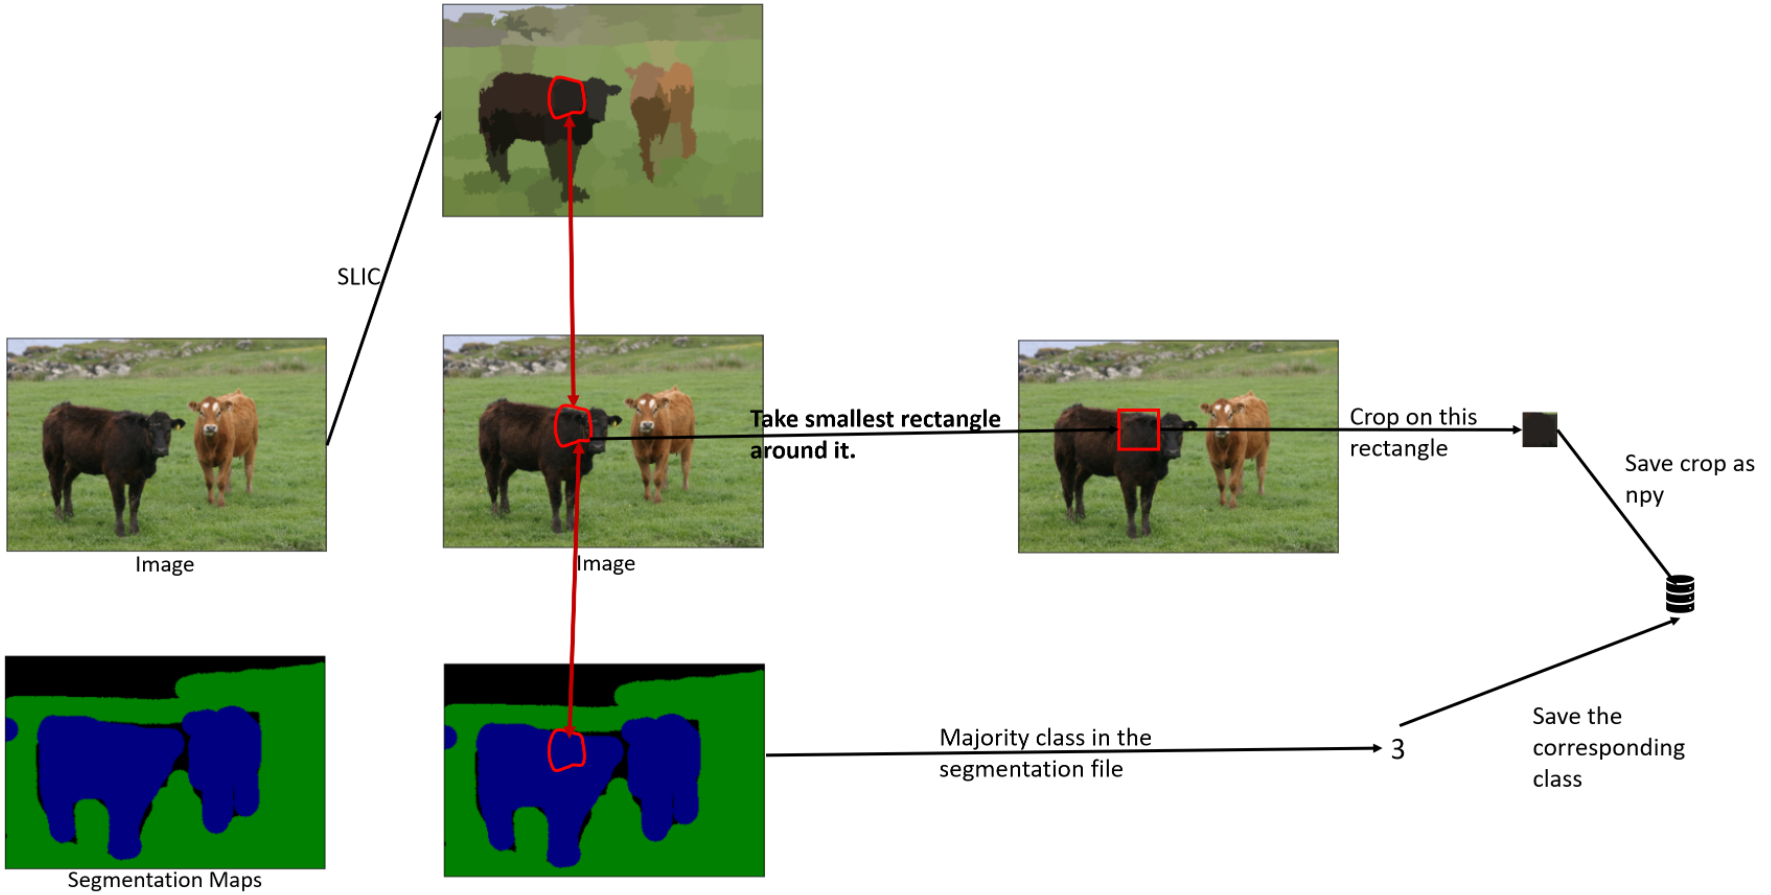

In [ ]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.



def get_rect_patch(indices):

    xmin, ymin = min(indices[1]), min(indices[0])
    xmax, ymax = max(indices[1]), max(indices[0])

    return xmin, ymin, xmax, ymax

def dilate_patch(rect_patch, W, H):
    x_min, y_min, x_max, y_max = rect_patch

    x_min = max(0, x_min - 3)
    y_min = max(0, y_min - 3)

    x_max = min(W, x_max+3)
    y_max = min(H, y_max+3)

    return x_min, y_min, x_max, y_max

def get_sp_patch(seg, i):
    indices = np.where(seg==i)

    if(len(indices[0]) == 0):
        return None
    rect_patch = get_rect_patch(indices)

    rect_patch = dilate_patch(rect_patch, seg.shape[1], seg.shape[0])
    x_min, y_min, x_max, y_max = rect_patch
    # cv2.rectangle(image_sample, (x_min,y_min), (x_max, y_max), (0,0,255), 2)
    # cv2.imshow("Test", image_sample)
    
    return rect_patch

def crop_image(img, rect_patch):

    return img[rect_patch[1]:rect_patch[3], rect_patch[0]:rect_patch[2], : ]




def get_seg_class(seg_patch):
    label_list=[]

    for i in range(seg_patch.shape[1]):
        for j in range(seg_patch.shape[0]):

            label=rgb_2_label[tuple(seg_patch[j,i])]
            label_list.append(label)

    return label_list[np.argmax(np.array(label_list))]




def make_dir(directory):
  dir_path = os.path.join(msrc_directory, directory)
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)
  return dir_path

current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'
datasets_dir = 'datasets'
train_dir = 'datasets/train'
test_dir = 'datasets/test'
datasets_path = os.path.join(msrc_directory, datasets_dir)
if not os.path.exists(datasets_path):
  os.mkdir(datasets_path)

datasets_path = make_dir(datasets_dir)
train_path = make_dir(train_dir)
test_path = make_dir(test_dir)


os.chdir(msrc_directory)
files_list = sorted(glob.glob("*.bmp"))

total_imgs = len(files_list)
train_files = files_list[ : int(0.8*total_imgs)]
test_files  = files_list[int(0.8*total_imgs) : ]
N_sp=100

def create_set(file_list, dir_path, csv_path):
    label_list=[]
    patch_list=[]
    
    for filename in tqdm(file_list):
        if '_GT' not in filename:
            target_filename = filename
            gt_filename = filename.replace(".bmp","_GT.bmp")

            image_sample = cv2.imread(os.path.join(msrc_directory, filename))
            image_sample = cv2.cvtColor(image_sample, cv2.COLOR_BGR2RGB)
            seg_sample = cv2.imread(os.path.join(msrc_directory, gt_filename))
            seg_sample = cv2.cvtColor(seg_sample, cv2.COLOR_BGR2RGB)

            slic_img = slic(image_sample, n_segments=N_sp, compactness=10)

            for i in range(N_sp):

                sp_patch_loc = get_sp_patch(slic_img, i)

                if sp_patch_loc is not None:
                    image_patch = crop_image(image_sample, sp_patch_loc)
                    gt_patch = crop_image(seg_sample, sp_patch_loc)
                    seg_class = get_seg_class(gt_patch) +1
                    label_list.append(seg_class)
                    image_patch_path = os.path.join(dir_path, filename.replace(".bmp","_NPY_"+str(i+1)+".npy"))
                    patch_list.append(image_patch_path)
                    np.save(image_patch_path, image_patch)
    data={"path" : patch_list, "label" : label_list}
    df=pd.DataFrame(data, columns = ["path", "label"])
    df.to_csv(csv_path, index = False, header=True)

create_set(train_files, train_path, os.path.join(train_path,"train.csv"))
create_set(test_files, test_path, os.path.join(test_path,"test.csv"))


100%|██████████| 96/96 [00:57<00:00,  1.67it/s]


Now, we can define the dataset and dataloader.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import pandas as pd
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from tqdm import tqdm

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):

    def __init__(self, dataset_path, csv, transform=None):
        
        df = pd.read_csv(os.path.join(dataset_path,csv))
        self.data = df['path']
        self.labels = df['label']
        self.size = len(self.data)
        self.transform = transform

            
    def __len__(self):
        
        return self.size
    
    def __getitem__(self, index):
        
        image_path = self.data[index]
        image = np.load(image_path, allow_pickle=True)
        label_i = int(self.labels[index])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_i)


transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])




## IMPORTANT

Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """


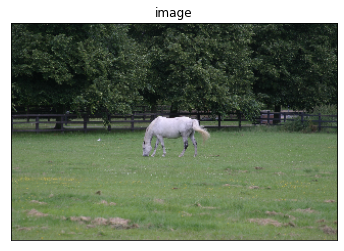

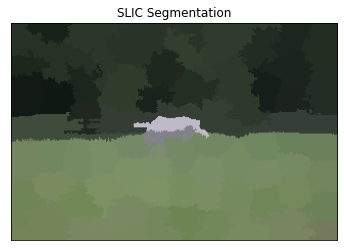

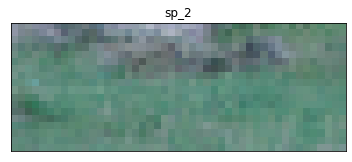

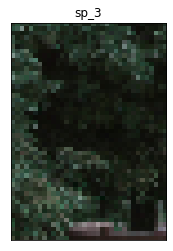

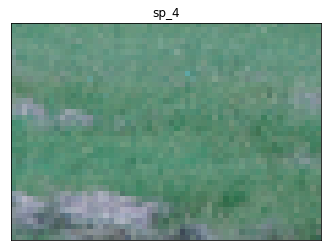

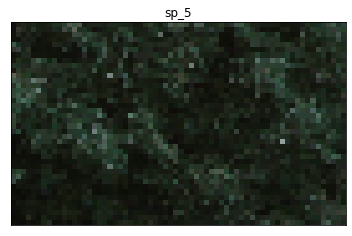

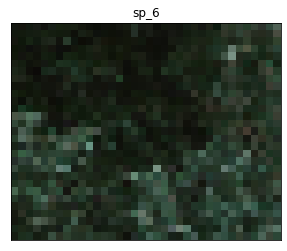

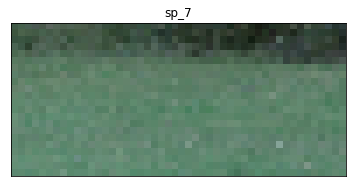

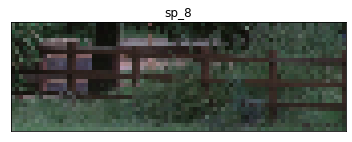

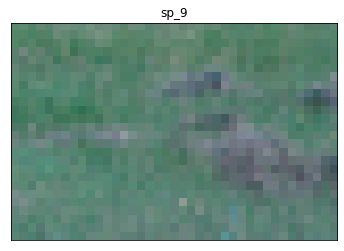

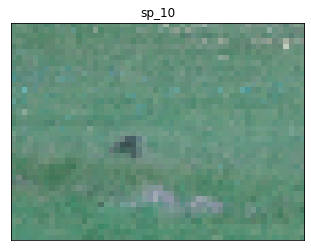

In [ ]:
### YOUR CODE TO PLOT 12 images (GT + superpixel map + first 10 superpixels) ###
sample_name = "1_25_s.bmp"
sample_test_data = cv2.imread(os.path.join(msrc_directory,"1_25_s.bmp"))

segments_sample = slic(sample_test_data, n_segments=100, compactness=10)
plot_image(sample_test_data, 'image')

superpixel_plot(sample_test_data, segments_sample, title = "SLIC Segmentation")
count=1
print()
for filename in glob.glob(msrc_directory+"/**/*.npy", recursive = True):
  
  sample_name=sample_name.replace(".bmp","")
  
  if sample_name in filename:
    count=count+1
    plot_image(np.load(filename),"sp_"+str(count))
    if count == 10:
      break



## Question 2: Deep Network (10 points)

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [ ]:

# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):
        super(SegmentationNN, self).__init__()

        self.model = models.vgg16(pretrained=True)
        for param in self.model.features.parameters():
            param.requires_grad = False
        num_features = self.model.classifier[6].in_features

        features = list(self.model.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Sequential(
                        nn.Linear(num_features, 2048), 
                        nn.ReLU(inplace=True), 
                        nn.Dropout(0.5),
                        nn.Linear(2048, 512), 
                        nn.ReLU(inplace=True), 
                        nn.Dropout(0.5),
                        nn.Linear(512, 10))]) 
        self.model.classifier = nn.Sequential(*features)
        

        for param in self.model.classifier.parameters():
            param.requires_grad=True

        print(self.model)
        self.model.to(device)





    def forward(self, x):
        y = self.model(x)

        return y

## Question 3: Optimizer (10 points) 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [ ]:


# Optimizer 
class Solver(object):
    def __init__(self, model, learning_rate):
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
        
        

    def train(self, data_loader, num_epochs=10):
        since = time.time()
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        

        for epoch in range(num_epochs):

            print("Epoch {}/{}".format(epoch, num_epochs))
            print('-' * 10)
        
            self.model.train()

            running_loss=0.0
            running_corrects=0
            
            for data in tqdm(data_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                

                self.optimizer.zero_grad()

                outputs = model(inputs)

                _, preds = torch.max(outputs, 1)

                loss = self.criterion(outputs, labels)

                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            
            epoch_loss = running_loss/train_len
            epoch_acc = running_corrects.double()/train_len

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                "Train", epoch_loss, epoch_acc))
           
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
       
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        return self.model

   



## Question 4: Putting it together (50 points) 

Start to train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map vs. ground truth segmentation map.

In [ ]:
train_data = SegmentationData(os.path.join(msrc_directory,train_dir), "train.csv", transform_train)
test_data = SegmentationData(os.path.join(msrc_directory,test_dir), "test.csv", transform_test)
train_len=len(train_data)
test_len=len(test_data)
print(train_len, test_len)
train_data_loader = data.DataLoader(dataset=train_data, batch_size=128, shuffle=True, num_workers=4)
test_data_loader = data.DataLoader(dataset=test_data, batch_size=128, shuffle=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using : ",device)


12145 2365
Using :  cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = SegmentationNN()
solver = Solver(model, 0.01)
solver.train(train_data_loader, num_epochs=5)


torch.save(model.state_dict(), 'ResNet18_v1.pt')
print("Training Done")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

  0%|          | 0/95 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.2169 Acc: 0.5890
Epoch 1/5
----------


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.5972 Acc: 0.8012
Epoch 2/5
----------


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.4917 Acc: 0.8370
Epoch 3/5
----------


100%|██████████| 95/95 [02:04<00:00,  1.31s/it]


Train Loss: 0.4258 Acc: 0.8557
Epoch 4/5
----------


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.3548 Acc: 0.8806
Training complete in 10m 27s
Best val Acc: 0.880609
Training Done


/content/MSRC_ObjCategImageDatabase_v1/1_19_s.bmp
Class :  -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  from ipykernel import kernelapp as app


Class :  -1
Class :  1
Class :  -1
Class :  1
Class :  1
Class :  1
Class :  -1
Class :  4
Class :  -1
Class :  1
Class :  1
Class :  -1
Class :  -1
Class :  -1
Class :  -1
Class :  1
Class :  3
Class :  3
Class :  3
Class :  3
Class :  -1
Class :  3
Class :  1
Class :  3
Class :  1
Class :  3
Class :  3
Class :  3
Class :  3
Class :  3
Class :  1
Class :  1
Class :  1
Class :  3
Class :  3
Class :  1
Class :  3
Class :  3
Class :  3
Class :  3
Class :  3
Class :  1
Class :  3
Class :  3
Class :  1
Class :  3
Class :  1
Class :  3
Class :  3
Class :  3
Class :  3
Class :  3
Class :  3
Class :  1
Class :  -1
Class :  3
Class :  1
Class :  3
Class :  3
Class :  1
Class :  -1
Class :  3
Class :  1
Class :  1
Class :  -1
Class :  1
Class :  1
Class :  -1


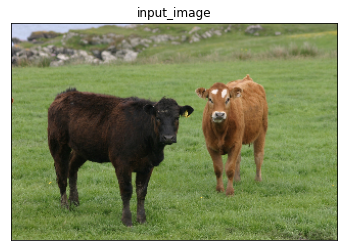

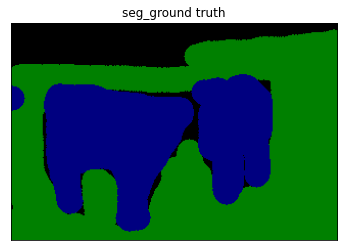

In [ ]:
#Try network inference on file
test_file_name = "1_19_s.bmp"

target_filename = test_file_name
gt_filename = target_filename.replace(".bmp","_GT.bmp")
print(os.path.join(msrc_directory, target_filename))
image_sample = cv2.imread(os.path.join(msrc_directory, target_filename))

plot_image(image_sample, 'input_image')
plot_image(seg_sample, 'seg_ground truth')

seg_sample = cv2.imread(os.path.join(msrc_directory, gt_filename))

N_sp=100
slic_img = slic(image_sample, n_segments=N_sp, compactness=10)
prediction=np.zeros(seg_sample.shape)

for i in range(N_sp):

    sp_patch_loc = get_sp_patch(slic_img, i)

    if sp_patch_loc is not None:
        image_patch = crop_image(image_sample, sp_patch_loc)
        cropped_image = transform_test(image_patch).to(device)
        cropped_image = cropped_image.unsqueeze(0)
        model.eval()
        pred_labels=model(cropped_image)
        _, preds = torch.max(pred_labels, 1)
        indices = seg_sample==i
        val = label_2_rgb[preds.item()-1]
        print("Class : ", preds.item()-1)
        

#Could not replace the superpixels with the classes due to being able to run only one cell at a time on colab.
# Hence the predicted labels are printed from inference

## Bonus Questions (20 points):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [ ]:
#TODO: Bonus


